In [1]:
from model import llm
from typing import TypedDict, List, Union, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

## Simple Agent

In [2]:
class AgentState(TypedDict):
    messages: List[HumanMessage]


def process(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print(f"\nAI: {response.content}")
    return state

In [3]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)
agent = graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [5]:
user_input = input("Enter: ")
while user_input != "exit":
    agent.invoke({"messages": [HumanMessage(content=user_input)]})
    user_input = input("Enter: ")


AI: Hi there! How can I help you today?

AI: As an AI, I don't have feelings or a physical body, so I don't experience "being" in the same way humans do. However, I am functioning perfectly and ready to assist you!

How are *you* doing today?


## Agent with Memory

In [19]:
class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]


def process(state: AgentState) -> AgentState:
    """This node will solve the request you input"""
    response = llm.invoke(state["messages"])

    state["messages"].append(AIMessage(content=response.content))
    print(f"\nAI: {response.content}")
    # print("CURRENT STATE: ", state["messages"])
    return state

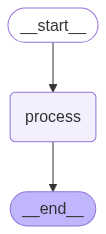

In [20]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)
agent = graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [27]:
conversation_history = []

In [30]:
user_input = input("Enter: ")
while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))
    result = agent.invoke({"messages": conversation_history})
    conversation_history = result["messages"]

    user_input = input("Enter: ")

with open("logging.txt", "w") as file:
    file.write("Your Conversation Log:\n")

    for message in conversation_history:
        if isinstance(message, HumanMessage):
            file.write(f"Human: {message.content}\n")
        elif isinstance(message, AIMessage):
            file.write(f"AI: {message.content}\n\n")
    file.write("End of Conversation")

print("Conversation saved to logging.txt")


AI: 2 + 2 = 4

AI: Your name is Romit.
Conversation saved to logging.txt


## React Agent

In [2]:
# email = Annotated[str, "Email address"]

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [4]:
@tool
def add(a: int, b: int) -> int:
    """Adds two numbers."""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtracts two numbers."""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers."""
    return a * b

tools = [add, subtract, multiply]
llm = llm.bind_tools(tools)

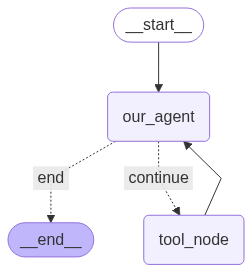

In [5]:
def model_call(state: AgentState) -> AgentState:
    """This node will solve the request you input"""
    system_prompt = SystemMessage(content = "You are my AI assistant. I will ask you to perform some tasks. You can use the tools provided to help you solve the tasks.")

    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState):
    """This node will check if the agent should continue or not"""
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tool_node", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tool_node",
        "end": END
    }
)

graph.add_edge("tool_node", "our_agent")

agent = graph.compile()
display(Image(agent.get_graph().draw_mermaid_png()))

In [8]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [12]:
inputs = {"messages": [("user", "add 40 + 12 and then multiply by 2. also tell me a gay joke")]}
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

add 40 + 12 and then multiply by 2. also tell me a gay joke
================================== Ai Message ==================================
Tool Calls:
  add (36666d7b-37a8-4233-9bf5-a5ddb405621e)
 Call ID: 36666d7b-37a8-4233-9bf5-a5ddb405621e
  Args:
    b: 12.0
    a: 40.0
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  multiply (ec9be95c-9449-461a-ad04-8f942c47c38d)
 Call ID: ec9be95c-9449-461a-ad04-8f942c47c38d
  Args:
    b: 2.0
    a: 52.0
================================= Tool Message =================================
Name: multiply

104
================================== Ai Message ==================================

The sum of 40 and 12 is 52, and then multiplying by 2 gives 104.

Why did the gay ghost go to the party?
Because he heard it was a *boo*-tiful